In [1]:
# load packages
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.io import RawArray
#from mne.channels.montage import get_builtin_montages
#from mne.datasets import fetch_fsaverage
#from mne.viz import set_3d_title, set_3d_view
sns.set_theme() # set the plotting atmosphere

### Import all files that will be sorted and exported into another .mat file

In [2]:
# Main Directory of processed file from MatLab
#MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[-1] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['AllMat', 'MAT', 'nl-345215-attnR_20240201_1637_RLS.mat']
Current WD: C:\plimon\LTP_analysis\eegMatFiles\nl-345215-attnR_20240201_1637_RLS.mat
Does File #1 Exist? True


#### Print Keys in original data

In [3]:
mat_data = scipy.io.loadmat(file_path1) # import data file
print((mat_data.keys()))

dict_keys(['__header__', '__version__', '__globals__', 'info', 'signalData', 'noise1', 'noise2'])


#### Index certain keys for analysis and conditions during expt

In [4]:
# find basic data parms 
MainData = mat_data['signalData']
noise1 = mat_data['noise1'] # 6 x 1 
noise2 = mat_data['noise2']
inds = mat_data['info'][0][0]
ExpConds = int(MainData.shape[0])
print(f'Data file contains data for {ExpConds} different conditions')

Data file contains data for 6 different conditions


### Channels to analyze derived from ryans selcted electrodes

In [5]:
# elecLeftLateral=[51,52,60,58,59,64,65,68,69]
# elecLeftMedial=[72,75,81,70,71,74]
# elecRightMedial=[72,75,81,76,83,82]
# elecMedial=[72,75,81,70,71,74,76,83,82]
# elecRightLateral=[97,92,85,96,91,95,90,94,88]

# AnalysisChans = [elecLeftLateral,elecLeftMedial,elecRightMedial,elecMedial,elecRightLateral]

# ExportChans = np.sort(np.concatenate(AnalysisChans)) # 39 chans
# print(ExportChans)

#elec_Arc1_outer = [68,64,58,51,47,42,37,31,    80,87,93,98,97,96,95,94]
elec_Arc2 = [73,69,65,59,52,53,54,  55,  79,86,92,91,90,89,88]
elec_Arc3 = [74,70,66,60,61,  78,85,84,83,82,  81]
elec_Arc4_inner = [71,67,62,77,76,75,     72]
# AllAnalysisChans = np.concatenate([elec_Arc1_outer,elec_Arc2,elec_Arc3,elec_Arc4_inner])
AllAnalysisChans = np.concatenate([elec_Arc2,elec_Arc3,elec_Arc4_inner])
AnalysisChans = np.unique(AllAnalysisChans)
AnalysisChans_int = np.array(AnalysisChans, dtype = int)
VisChans = np.sort(AnalysisChans)

#### Make Bool mask for mne topoplots

In [6]:
OcciMask = np.zeros((128), dtype = bool) # mask of len nchans
OcciMask[VisChans] = True # set good chans to true 
print(OcciMask)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True False False False  True
  True  True  True False False  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True False  True  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]


In [7]:
# save signal data
FreqDataPerCo = {}
for co in range(ExpConds):
    #print(MainData[co][0].shape)
    FreqDataPerCo[co] = MainData[co][0]
# noise data 1 
Noise1DataPerCo = {}
for co in range(ExpConds):
    #print(noise1[co][0].shape)
    Noise1DataPerCo[co] = noise1[co][0]
# noise data 2
Noise2DataPerCo = {}
for co in range(ExpConds):
    #print(noise2[co][0].shape)
    Noise2DataPerCo[co] = noise2[co][0]

In [8]:
co = 0 # pre and post induction ltp
HarmInd = np.ravel(mat_data['info'][0][0] [0][co][0])
BinInd = np.ravel(mat_data['info'][0][0] [1][co][0])
#HarmonLabels = mat_data['info'][0][0][2][co][0]
AvgAct = mat_data['info'][0][0] [3][co] [0] # returns an array with 6 values ...
NumCondInd = mat_data['info'][0][0][4][co][0] # bin index, includes preludes
HemiFieldLabels = mat_data['info'][0][0] [2][co][0] # contains harmonic and hemifield data
hemiFieldnHarmonicInd = mat_data['info'][0][0] [2][co] [0]
#########IN case some nexted arrays need to be extracted or explored
# co = 0
# ind = 2
# inds = mat_data['info'][0][0] [ind][co] [0] # avoid prelude bind which == 0 actually 
# #print(inds)
# for innerlist in inds:
#     for item in innerlist:
#        print(item)

In [9]:
HemiBound = int(int(len(HemiFieldLabels))/2)
print(HemiBound) # index for Fx filter freq

4


#### have to combine real and imaginar before data can be indexed 

In [10]:
NumHarms,NumHarmCount = np.unique(HarmInd, return_counts = True)
print(f'Hamronics:  {NumHarms,NumHarmCount}')
NumBins,NumBinCount = np.unique(BinInd, return_counts = True)
print(f'Bin Indicies:  {NumBins,NumBinCount}')

Bins = int(len(NumBins)-1)

Hamronics:  (array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([7, 7, 7, 7, 7, 7, 7, 7], dtype=int64))
Bin Indicies:  (array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([8, 8, 8, 8, 8, 8, 8], dtype=int64))


In [11]:
print(HarmInd[0:7])
print(BinInd[0:7])


[1 1 1 1 1 1 1]
[0 1 2 3 4 5 6]


In [12]:
SortDataIn =  FreqDataPerCo[0] # 112 x 128 x 78
[NumRows, NumChans, NumTrials] = SortDataIn.shape # get dims of data to use later ..
print(SortDataIn.shape)
real_imag_bound = int((NumRows/2))
print(f'Data real-imag bound is at row: #{real_imag_bound}')
chanInd = np.arange(1,NumChans,1)
prepost_bound = int(NumTrials/2)

(112, 128, 78)
Data real-imag bound is at row: #56


#### Combine Real and Imaginary Components of data

In [13]:
# segment data into real and imaginary data side by side
dIn = FreqDataPerCo[co].reshape(real_imag_bound,2,NumChans,NumTrials, order =  'A') # 56 x 2 x 128 x 78
n1 = Noise1DataPerCo[co].reshape(real_imag_bound,2,NumChans,NumTrials, order = 'A')
n2 = Noise2DataPerCo[co].reshape(real_imag_bound,2,NumChans,NumTrials, order = 'A')


In [14]:
# dOut_r = FreqDataPerCo[co][:real_imag_bound,:,:]
# dOut_i = FreqDataPerCo[co][real_imag_bound:,:,:]
# print(dIn[0:10,1,0,0])
# print()
# print(dOut_r[0:10,0,0])
# print()
# print(dOut_i[0:10,0,0])

In [15]:
# remove 0s -> nans
dIn[dIn == 0] = np.nan
n1[n1 == 0] = np.nan
n2[n2 == 0] = np.nan
# combine real and imaginary compnents for signal data, noise 1 and noise 2 
DataOut = np.zeros((real_imag_bound,NumChans,NumTrials))
n1Out = np.zeros_like(DataOut)
n2Out = np.zeros_like(DataOut)

for val in range(real_imag_bound):
    DataOut[val,:,:] = np.hypot(dIn[val,0,:,:],dIn[val,1,:,:]) # (56,128, 78)
    n1Out[val,:,:] = np.hypot(n1[val,0,:,:],n1[val,1,:,:]) # (56, 128, 78)
    n2Out[val,:,:] = np.hypot(n2[val,0,:,:],n2[val,1,:,:]) # (56, 128, 78)

print(DataOut.shape)

(56, 128, 78)


#### Get data per bin and store in dict, remove prelude bins

In [16]:
dataPerBin = {}

for i in range(len(NumBins)):
    if i > 0:
        bin_arr = np.zeros_like((BinInd))
        bin_arr[BinInd == i] = 1
        dataPerBin[i-1] = DataOut[bin_arr == 1,:,:]

#### F1 and F2 data are stacked on top of each other so here we split them :)

In [17]:
xF1Bins = {} # data is : 2f1 4f1 6f1 8f1
xF2Bins = {} # data is  2f2 4f2 6f2 8f2

for i in range(6):
    data2split = dataPerBin[i] # 8 x 128 x 78

    xF1Bins[i] = np.array(data2split[:HemiBound,:,:])# harmonics x channels x trials  = 4 x 128 x 78
    xF2Bins[i] = np.array(data2split[HemiBound:,:,:]) # harmonics x channels x trials 

Channel activity per trial: harmonic, bin and hemifield


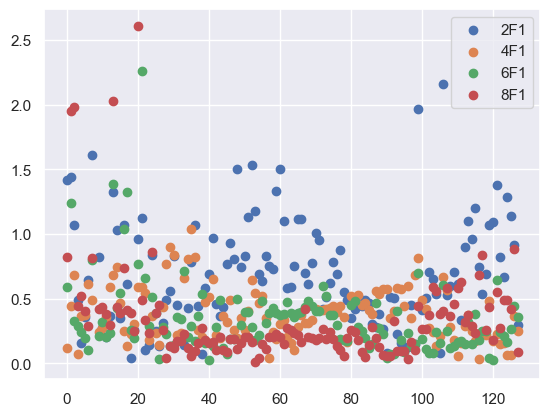

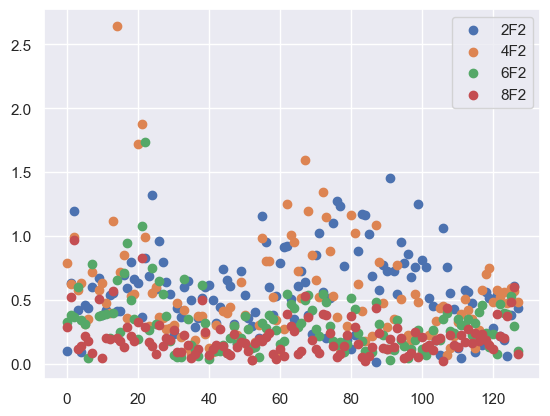

In [18]:
pickBin = 4
print(f'Channel activity per trial: harmonic, bin and hemifield')
ch_list = np.arange(0,NumChans,1)
for i in range(4):
    plt.scatter(ch_list,xF1Bins[pickBin][i,:,70], label = f'{(i+1)*2}F1') # plot per channel actiivity 
    plt.legend()
plt.show()

for i in range(4):
    plt.scatter(ch_list,xF2Bins[pickBin][i,:,70], label = f'{(i+1)*2}F2') # plot per channel actiivity 
    plt.legend()
plt.show()

### seperate data into pre and post 

In [23]:
prepost_bound= int(NumTrials/2) # reshape will occure at this ind 

xF1_pre_post = {} # F1 pre post data
xF2_pre_post = {} # F2 pre post data

for i in range(6):
    xF1_pre_post[i] = np.reshape(xF1Bins[i], newshape = (4,NumChans,prepost_bound,2), order = 'F')
    xF2_pre_post[i] = np.reshape(xF2Bins[i], newshape = (4,NumChans,prepost_bound,2), order = 'F') # 4 x 128 x pre / post trials  x 2# 

In [26]:
# xF1Bins[0].shape

# trialdata = xF1_pre_post[0]
# print(trialdata.shape)
# print(trialdata[0,0,0:5,1])
# print()

# pre_t = xF1Bins[0][:,:,:prepost_bound]
# post_t = xF1Bins[0][:,:,prepost_bound:]

# print(pre_t[0,0,0:5])
# print()
# print(post_t[0,0,0:5])
# print()

#### visualize data not for analysis - data is not comperable but more to make sure there is variance between trials, hemifields and harmonics

channel activity per trial: harmonic, bin and hemifield


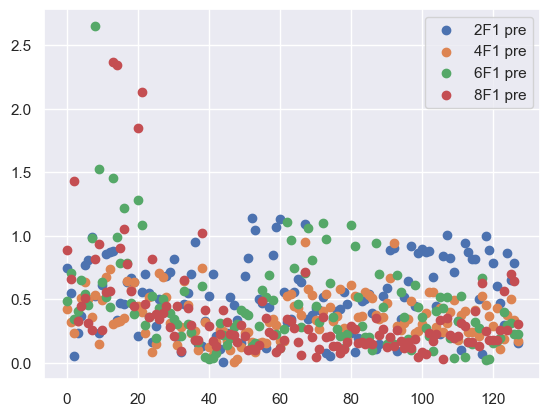

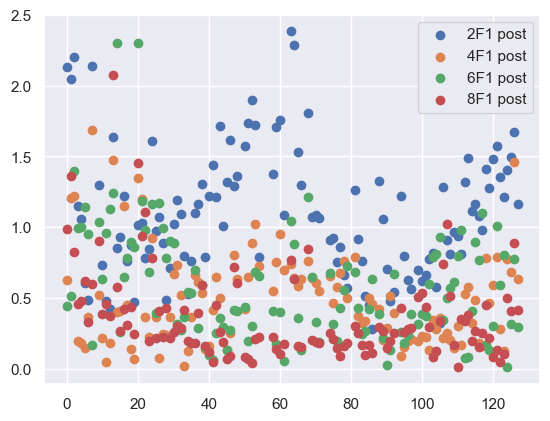

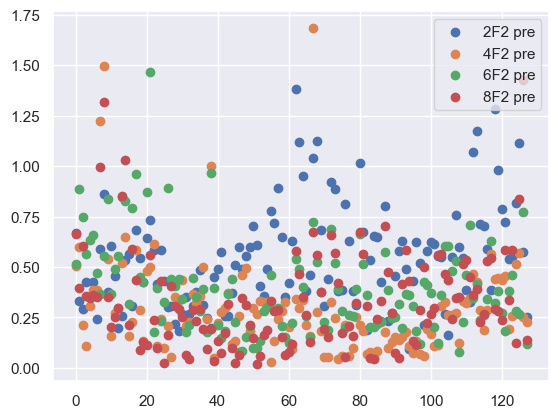

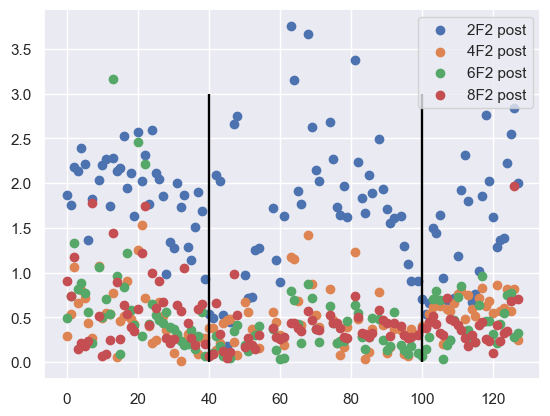

In [27]:
pickBin = 2
print(f'channel activity per trial: harmonic, bin and hemifield')
ch_list = np.arange(0,NumChans,1)

for i in range(4):
    plt.scatter(ch_list,xF1_pre_post[pickBin][i,:,19,0], label = f'{(i+1)*2}F1 pre') # plot per channel actiivity 
    plt.legend()
plt.show()
for i in range(4):
    plt.scatter(ch_list,xF1_pre_post[pickBin][i,:,19,1], label = f'{(i+1)*2}F1 post') # plot per channel actiivity 
    plt.legend()
plt.show()

for i in range(4):
    plt.scatter(ch_list,xF2_pre_post[pickBin][i,:,19,0], label = f'{(i+1)*2}F2 pre') # plot per channel actiivity 
    plt.legend()
plt.show()
for i in range(4):
    plt.scatter(ch_list,xF2_pre_post[pickBin][i,:,19,1], label = f'{(i+1)*2}F2 post') # plot per channel actiivity 
    plt.vlines(40, ymin = 0 , ymax = 3, color = 'black')
    plt.vlines(100, ymin = 0, ymax = 3, color = 'black')
    plt.legend()
plt.show()

#### concate data across bins to create avg activity per channel per bin

In [28]:
xF1_CleanAvgs = {}
xF2_CleanAvgs = {}

for prepost in range(2):
    xF1_CleanAvgs[prepost] = {} # make a new dict key for pre and then post 
    xF2_CleanAvgs[prepost] = {}
    for bin in range(6):
        #enter data dict
        xF1_dIn = xF1_pre_post[bin] # 4  x 128 x ntrials x pre / post
        xF2_dIn = xF2_pre_post[bin]
        # avg harmonic activity per channel
        xF1_CleanAvgs[prepost][bin] = np.nanmean(xF1_dIn[:,:,:,prepost],axis = -1) # average data per trial to get 1 val per channel
        xF2_CleanAvgs[prepost][bin] = np.nanmean(xF2_dIn[:,:,:,prepost],axis = -1) # average data per trial to get 1 val per channel

#### Sanity check plot

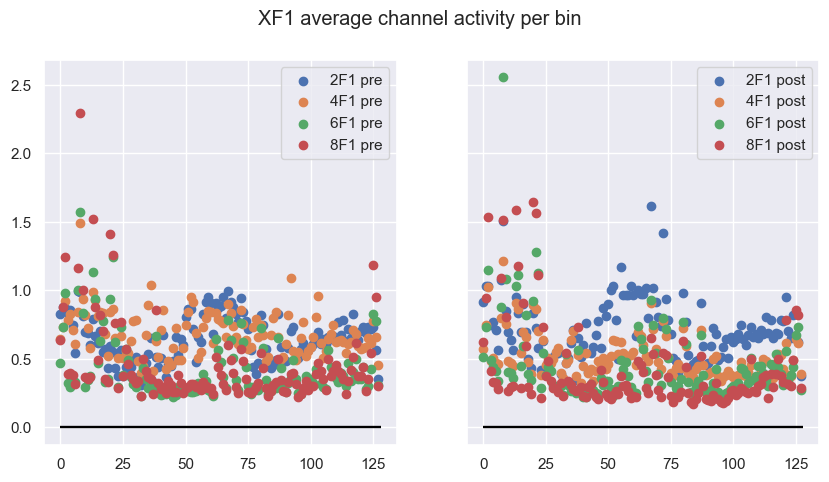

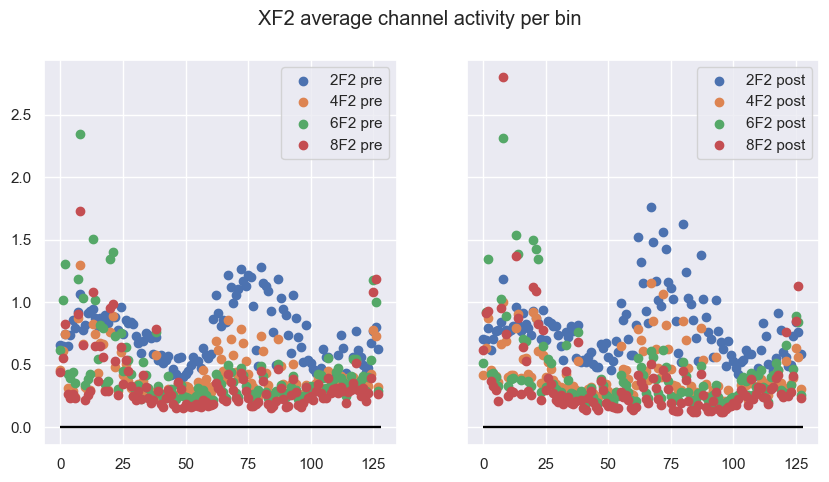

In [29]:
pepo = ['pre', 'post']

binInd = 4
fig, axs = plt.subplots(1,2,figsize = (10,5),sharey = True)
for prepost in range(2):
    dIn = xF1_CleanAvgs[prepost]
    for hi in range(4):
        axs[prepost].scatter(ch_list,dIn[binInd][hi,:], label = f'{(hi+1)*2}F1 {pepo[prepost]}')
        axs[prepost].hlines(0,xmin = 0,xmax = 128, color = 'black')
    plt.suptitle('XF1 average channel activity per bin')
    axs[prepost].legend()


fig, axs = plt.subplots(1,2,figsize = (10,5),sharey = True)
for prepost in range(2):
    dIn = xF2_CleanAvgs[prepost]
    for hi in range(4):
        axs[prepost].scatter(ch_list,dIn[binInd][hi,:], label = f'{(hi+1)*2}F2 {pepo[prepost]}')
        axs[prepost].hlines(0,xmin = 0,xmax = 128, color = 'black')
    plt.suptitle('XF2 average channel activity per bin')
    axs[prepost].legend()


#### Combine data across harmonics 

In [30]:
XF1_Data = {}
XF2_Data = {}

for prepost in range(2):
    XF1_Data[prepost] = {}
    XF2_Data[prepost] = {}

    temp_XF1 = np.concatenate([xF1_CleanAvgs[prepost][x] for x in xF1_CleanAvgs[prepost]])
    temp_XF2 = np.concatenate([xF2_CleanAvgs[prepost][x] for x in xF2_CleanAvgs[prepost]])

    XF1_Data[prepost] = np.reshape(temp_XF1, newshape = (4,6,NumChans))
    XF2_Data[prepost] = np.reshape(temp_XF2, newshape =(4,6,NumChans))


In [35]:
# print(temp_XF1.shape)
# print(XF1_Data[1].shape)
# print()

# print(temp_XF1[6:12,0]) # 24 x 128 
# print()
# print(XF1_Data[1][1,:,0])

(24, 128)
(4, 6, 128)

[0.62407844 0.66393267 0.67644574 0.575047   0.5362182  0.6532406 ]

[0.62407844 0.66393267 0.67644574 0.575047   0.5362182  0.6532406 ]


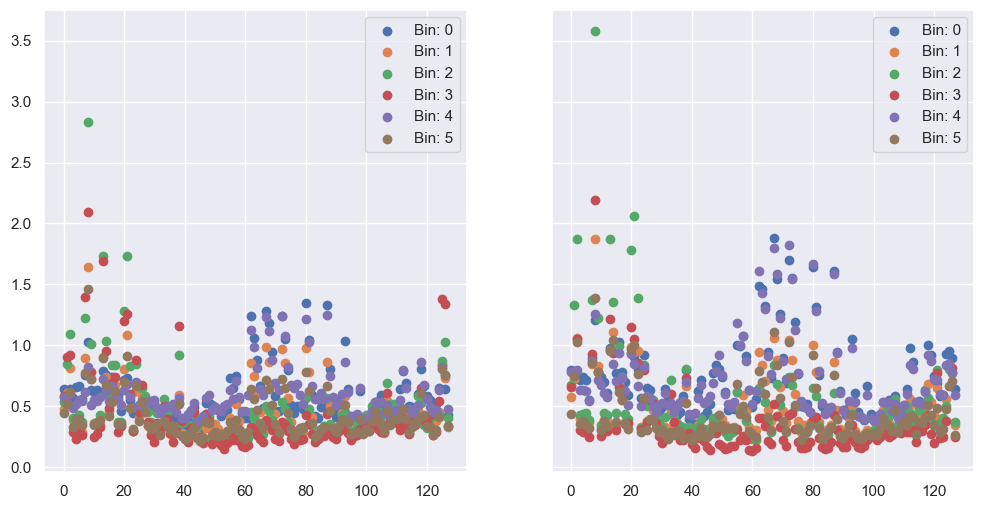

In [36]:
fig,axs = plt.subplots(1,2, figsize = (12,6), sharey = True)

for pltpos in range(2):
    pepo = XF2_Data[pltpos] # plot pre and post data
    for i in range(6):
        harmtwo  = pepo[0,i,:]
        ht = np.nanmean(harmtwo,axis = 0) # 128 points of avg channel activity pre or post 
        axs[pltpos].scatter(ch_list,harmtwo, label = f'Bin: {i}')
        axs[pltpos].legend()
# plt.title(f'activity per channel across all bins')

## Compute Difference in response activity post - pre and then the other manner in which ryan suggested it ..

## pre data 

In [37]:
f1_temp_pre = XF1_Data[0] # 4 x 6 x 128
f1_temp_post = XF1_Data[1] # 4 x 6 x 128

XF1_diffs = np.zeros_like((f1_temp_pre)) # temporary store of data 

for hi in range(4):
    for bin in range(6):
        diff = (f1_temp_post[hi,bin,:] - f1_temp_pre[hi,bin,:])
        XF1_diffs[hi,bin,:] = diff

## post data

In [38]:
f2_temp_pre = XF2_Data[0] # 4 x 6 x 128
f2_temp_post = XF2_Data[1] # 4 x 6 x 128

XF2_diffs = np.zeros_like((f2_temp_pre)) # temporary store of data 

for hi in range(4):
    for bin in range(6):
        diff = (f2_temp_post[hi,bin,:] - f2_temp_pre[hi,bin,:])
        XF2_diffs[hi,bin,:] = diff

#### is data different? - checkpoint 

In [39]:
if np.sum(XF1_diffs == XF2_diffs) == 0:
    print(f'Data does not overlap, good sign') # check if data is the same
else:
    print(f'check data indcies as data is the same for both hemifields')

Data does not overlap, good sign


#### Select Harmonic Data to visualize, transpose data and add dead channel for right now

### XF1 difference data + dead chan

In [40]:
Harmonic = 0
topodata_f1 = XF1_diffs[Harmonic,:,:].T  # 128 x 6 - 0 -== 2f
#have to add some fake channel data because egi file includes one extra channel
emptyChData = np.zeros((1,6)) # 1 x 6
F1_Diffs = np.array(np.concatenate((topodata_f1,emptyChData))) # 129 x 6 
print(F1_Diffs.shape)

(129, 6)


### XF2 difference data + dead chan

In [41]:
topodata_f2 = XF2_diffs[Harmonic,:,:].T  # 128 x 6 - 0 -== 2f
#have to add some fake channel data because egi file includes one extra channel
F2_Diffs = np.array(np.concatenate((topodata_f2,emptyChData))) # 129 x 6 
print(F2_Diffs.shape)

(129, 6)


## Plot topographies

# Select EEG Montage to be used for MNE

## Import and Set EEG Sensor Location File and Set as Default Montage

In [42]:
eegMontageDir = 'C:\\plimon\\LTP_analysis\\eegSensorLocs\\9_18AverageNet128_v1.sfp'#AdultAverageNet128_v1.sfp'
# Check if the file exists
if os.path.exists(eegMontageDir):
    # Load the electrode locations file
    montageIn = mne.channels.read_custom_montage(eegMontageDir) # import file
    print("Electrode locations loaded successfully.")
else:
    print("The specified file does not exist.")
print(montageIn)
#### Get channel names to use
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)

Electrode locations loaded successfully.
<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 129 channels>


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,132 points
Good channels,129 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1.00 Hz
Highpass,0.00 Hz
Lowpass,0.50 Hz


#### mask Channels Not of interest - have to add 1 more bool for reference channel

In [43]:
OcciChansMask = OcciMask
deadChan = True
ocm = np.array(np.hstack((OcciChansMask, deadChan)))
print(ocm)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True False False False  True
  True  True  True False False  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True False  True  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True]


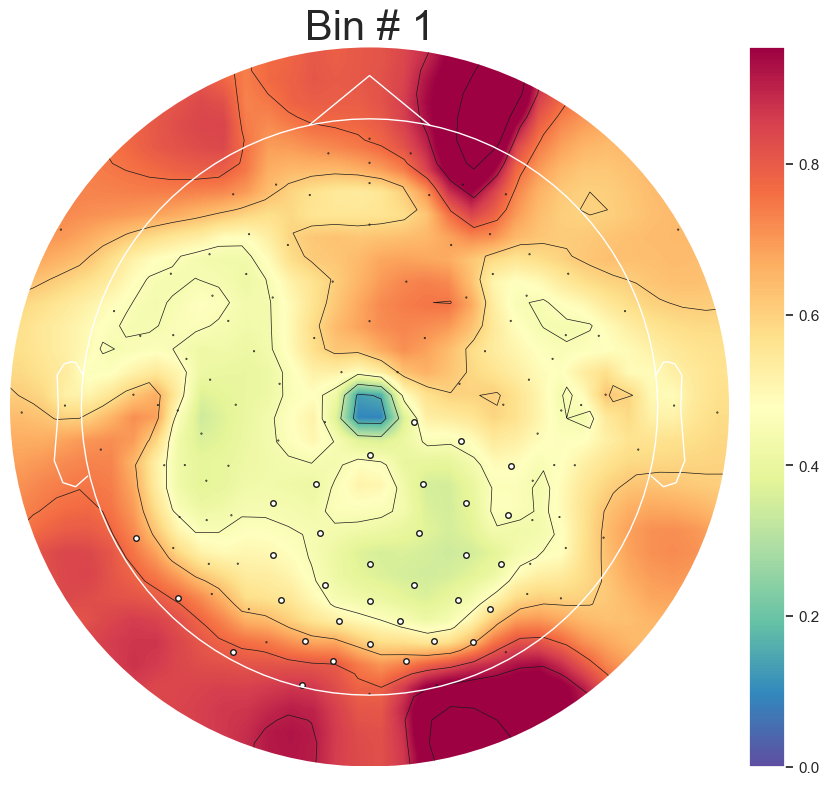

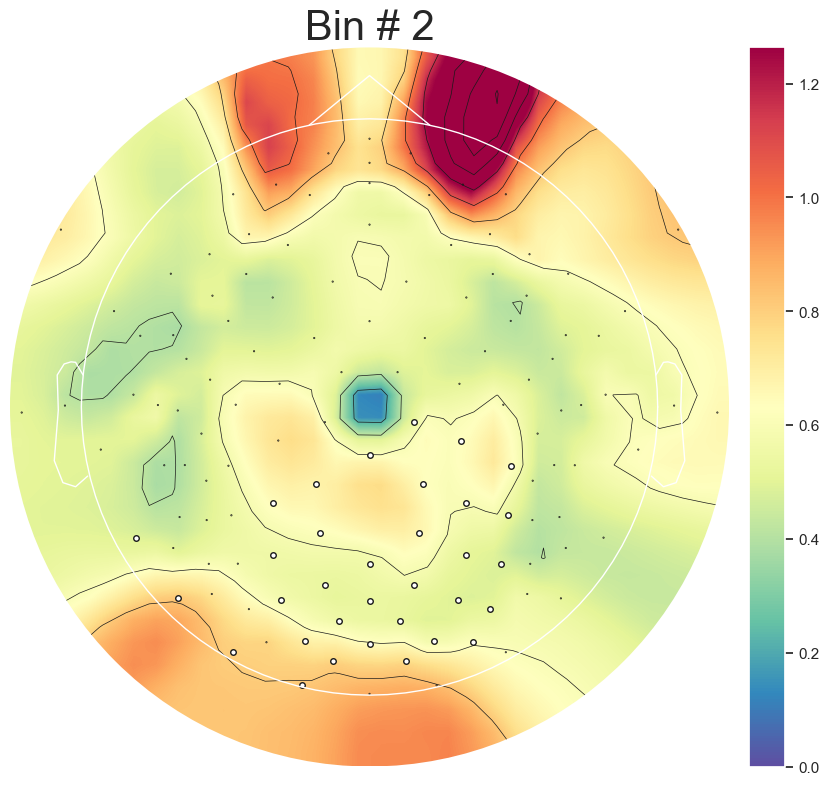

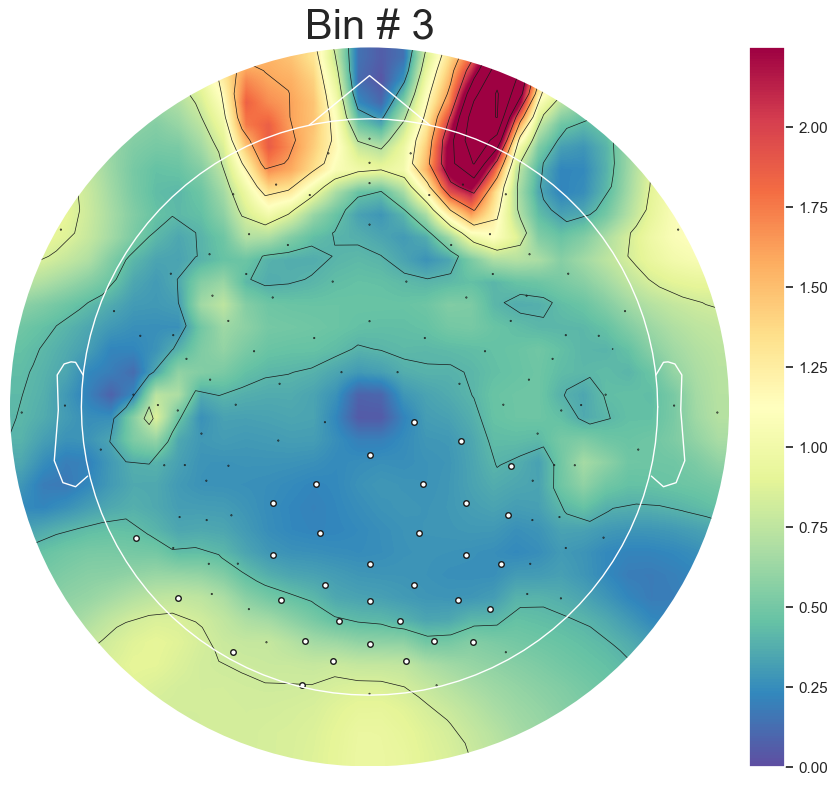

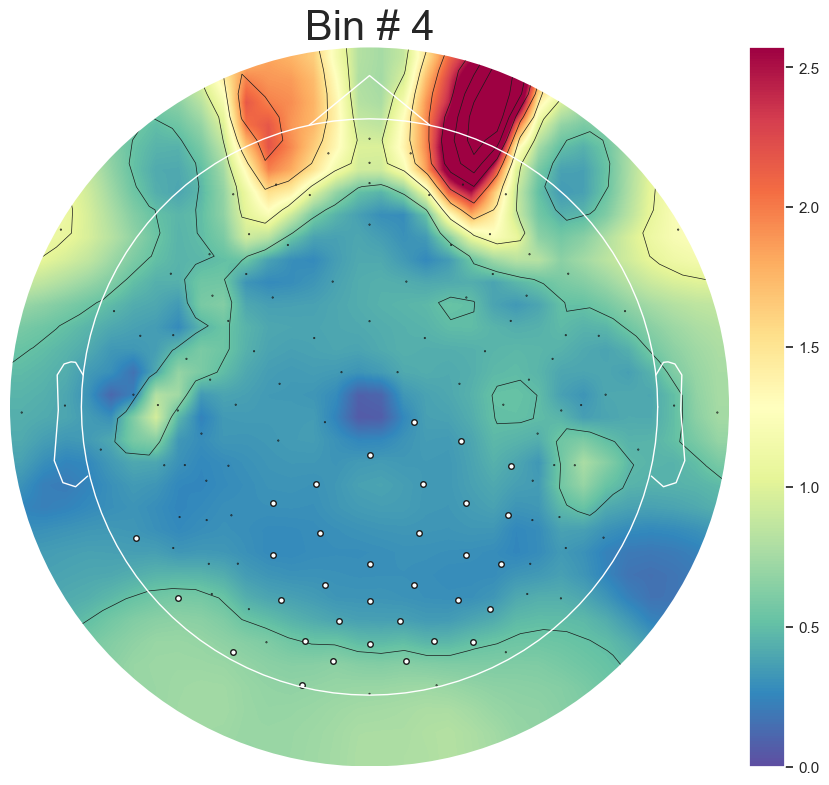

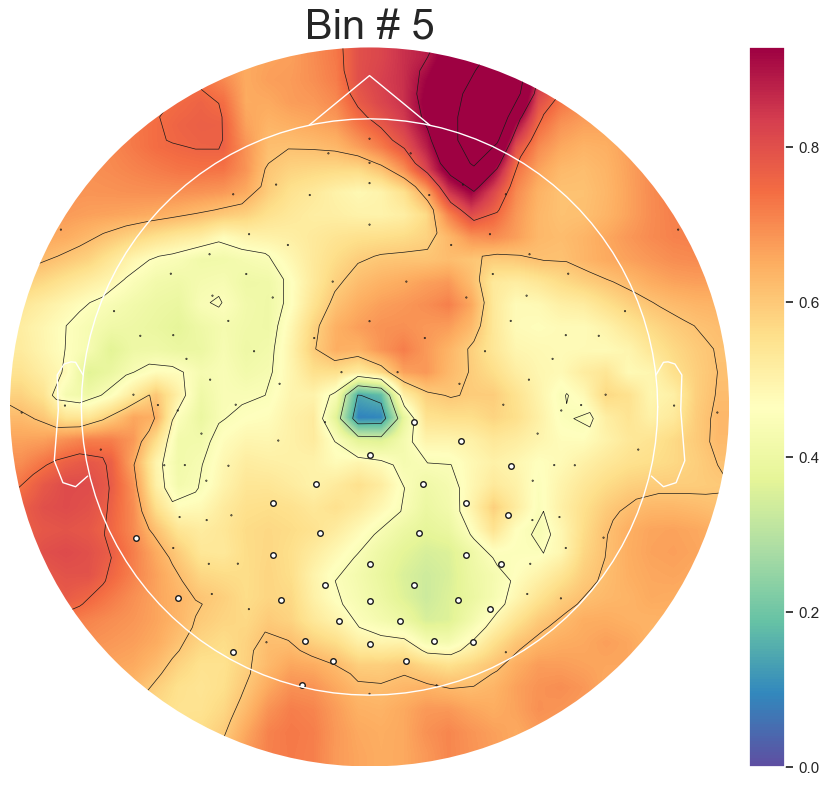

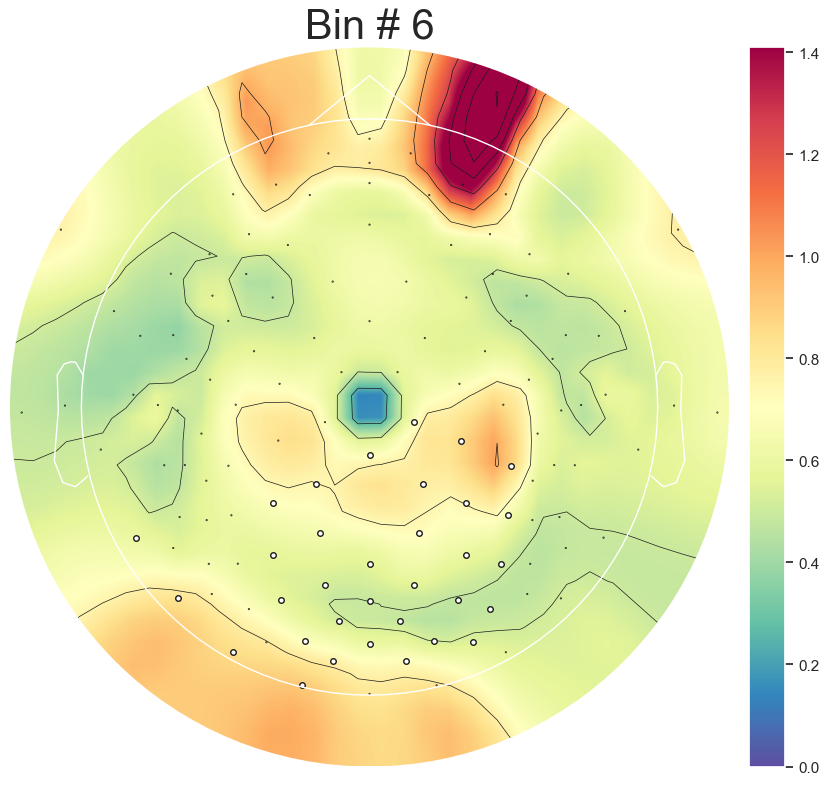

In [45]:
p = XF1_Data[0]

topodata = p[0,:,:].T  # 128 x 6 - 0 -== 2f
#have to add some fck channel data because egi file included one extra channel
emptyChData = np.zeros((1,6)) # 1 x 6
data = np.array(np.concatenate((topodata,emptyChData))) # 129 x 6 

for i in range(6):
    #plt.plot(topodata[:,i])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'Bin # {i+1}', fontsize = 30)
    #placeholder = np.random.random((10, 10))
    #axs.imshow(placeholder)
    axes.axis('off')

    dataIn = data[:,i]
    #dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info,mask = OcciMask, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 8)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
p = XF1_Data[1]

topodata = p[0,:,:].T  # 128 x 6 - 0 -== 2f
#have to add some fck channel data because egi file included one extra channel
emptyChData = np.zeros((1,6)) # 1 x 6
data = np.array(np.concatenate((topodata,emptyChData))) # 129 x 6 


for i in range(6):
    #plt.plot(topodata[:,i])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'Bin # {i+1}', fontsize = 30)
    #placeholder = np.random.random((10, 10))
    #axs.imshow(placeholder)
    axes.axis('off')

    dataIn = data[:,i]
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 8)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

#### Plot F1 Difference post induction

In [ ]:
for i in range(6):
    #plt.plot(topodata[:,i])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'F1 response change post induction, Bin # {i+1}', fontsize = 30)
    #placeholder = np.random.random((10, 10))
    #axs.imshow(placeholder)
    axes.axis('off')

    dataIn = F1_Diffs[:,i]
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 8)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

##### Ploting F2 Data Now, 2nd harmonic

In [ ]:
p = XF2_Data[0]

topodata = p[0,:,:].T  # 128 x 6 - 0 -== 2f
#have to add some fck channel data because egi file included one extra channel
emptyChData = np.zeros((1,6)) # 1 x 6
data = np.array(np.concatenate((topodata,emptyChData))) # 129 x 6 

for i in range(6):
    #plt.plot(topodata[:,i])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'Bin # {i+1}', fontsize = 30)
    #placeholder = np.random.random((10, 10))
    #axs.imshow(placeholder)
    axes.axis('off')

    dataIn = data[:,i] # 129 array
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 8)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
p = XF2_Data[1]

topodata = p[0,:,:].T  # 128 x 6 - 0 -== 2f
#have to add some fck channel data because egi file included one extra channel
emptyChData = np.zeros((1,6)) # 1 x 6
data = np.array(np.concatenate((topodata,emptyChData))) # 129 x 6 

for i in range(6):
    #plt.plot(topodata[:,i])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'Bin # {i+1}', fontsize = 30)
    #placeholder = np.random.random((10, 10))
    #axs.imshow(placeholder)
    axes.axis('off')

    dataIn = data[:,i]
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 8)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
for i in range(6):
    #plt.plot(topodata[:,i])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'F1 response change post induction, Bin # {i+1}', fontsize = 30)
    #placeholder = np.random.random((10, 10))
    #axs.imshow(placeholder)
    axes.axis('off')

    dataIn = F1_Diffs[:,i]
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 8)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
for i in range(6):
    #plt.plot(topodata[:,i])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'F2 response change post induction, Bin # {i+1}', fontsize = 30)
    #placeholder = np.random.random((10, 10))
    #axs.imshow(placeholder)
    axes.axis('off')

    dataIn = F2_Diffs[:,i]
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 8)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

### Maybe dont have the correct egi corrdinates(?) - have to  add an additional row to make up for last channel missingmaybe ref (should keep as nan maybe )

In [ ]:
# topodata = p[0,:,:].T
# print(topodata.shape)
# emptyChData = np.zeros((1,6))
# print(emptyChData.shape)

# dataFull = np.array(np.concatenate((topodata,emptyChData)))

# data = dataFull[:,4]

# # create array with 4 points for our 4 channels
# # in the same order as provided in ch_names
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10),gridspec_kw=dict(height_ratios=[3]))
# axes.set_title(f'subj topo plot', fontsize = 30)
# # placeholder = np.random.random((10, 10))
# # axes.imshow(placeholder)
# axes.axis('off')

# #info = create_info(ch_names=montageIn._names, sfreq=1, ch_types='eeg')
# # channel names I provided are part of a standard montage
# #info.set_montage(montageIn) # import file)
# im,_ = plot_topomap(data, info, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 8)
# divider = make_axes_locatable(axes)
# cax = divider.append_axes('right', size='5%', pad=0.2)
# cbar = plt.colorbar(im, cax=cax)
# plt.show()

### Good confined example of what data formate is supposed to look like for mne plotting success

In [ ]:
# from mne import create_info
# from mne.viz import plot_topomap
# import numpy as np

# # create array with 4 points for our 4 channels
# # in the same order as provided in ch_names
# data = np.random.randn(4)  
# info = create_info(ch_names=['CPz', 'Oz', 'POz', 'Fz'], sfreq=1000, ch_types='eeg')
# # channel names I provided are part of a standard montage
# info.set_montage('standard_1020')

# plot_topomap(data, info)

In [ ]:
# topodata = p[0,:,:].T  # 128 x 6 - 0 -== 2f
# #have to add some fck channel data because egi file included one extra channel
# emptyChData = np.zeros((1,6)) # 1 x 6
# data = np.array(np.concatenate((topodata,emptyChData))) # 129 x 6 


# for i in range(6):
#     #plt.plot(topodata[:,i])
#     fig, axs = plt.subplots(figsize = (6,6))
#     axs.set_title(f'Bin # {i}')
#     axs.legend()
#     print(i)
#     dataIn = data[:,i]
#     mne.viz.plot_topomap(dataIn, info, axes = axs)

#### plot formats of the past and present(?)

In [ ]:
# fig = plt.figure(figsize = (10,10))
# ax = fig.add_subplot(111, projection='3d')
# montageIn.plot(kind='3d', axes=ax)
# ax.set_title('Sensor Locations')
# plt.show()
# # Plot the sensors on a 2D head model
# fig, ax = plt.subplots()
# montageIn.plot(kind='topomap', show_names=True, axes=ax)
# ax.set_title('Sensor Locations (2D)')
# plt.show()

In [ ]:
# montge default info in case egi outut file fails me 
# #montage_type = mne.channels.make_standard_montage("GSN-HydroCel-128")
# print(montage_type)

In [ ]:
# h_label = ['2F','4F','6F','8F']

# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF1_Data[0][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Pre F1 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')
#plt.show()
# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF1_Data[1][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Post F1 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')
# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF2_Data[0][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Pre F2 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')
# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF2_Data[1][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Post F2 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')